# **SBERT-Based Multi-label Emotion Classifier with NRC-VAD**

In [1]:
# Import necessary libraries (ensure these are all installed)
!pip install -q git+https://github.com/trent-b/iterative-stratification.git
!pip install -q transformers torch scikit-learn pandas numpy matplotlib seaborn accelerate Jinja2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from accelerate import Accelerator
import matplotlib.pyplot as plt
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
import json
from collections import Counter
import math

In [3]:
# --- Configuration ---
# Grouping hyperparameters and settings here improves readability and maintainability
class Config:
    DATA_PATH = "balanced_df.csv"
    VAD_LEXICON_PATH = "NRC-VAD-Lexicon.txt"
    MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
    MAX_LENGTH = 256
    BATCH_SIZE = 32
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 15
    DROPOUT_RATE = 0.3
    N_SPLITS = 5
    RANDOM_STATE = 42
    THRESHOLD = 0.5
    CHECKPOINT_DIR = "checkpoints/best_model"
    OUTPUT_DIR = "outputs"
    PDF_FILENAME = "evaluation_plots.pdf"
    MODEL_ZIP_FILENAME = "best_model.zip"

config = Config()

# --- Create Output Directory ---
Path(config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(config.CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
# --- Data Loading and Initial Preprocessing ---
print("Loading data...")
try:
    balanced_df = pd.read_csv(config.DATA_PATH)
    nrc_vad = pd.read_csv(config.VAD_LEXICON_PATH, sep='\t')
    nrc_vad.columns = ["word", "valence", "arousal", "dominance"]
    nrc_vad.set_index("word", inplace=True)
except FileNotFoundError as e:
    print(f"Error loading data file: {e}. Please ensure '{config.DATA_PATH}' and '{config.VAD_LEXICON_PATH}' exist.")
    # Exit or raise exception if critical files are missing
    raise e

print("Preprocessing data...")
balanced_df = balanced_df.dropna(subset=["utterance", "emotion"])
balanced_df = balanced_df.reset_index(drop=True)


Loading data...
Preprocessing data...


In [5]:
# Convert comma-separated string to list of emotions
def parse_emotions(emotion_str):
    if isinstance(emotion_str, str):
        return [e.strip() for e in emotion_str.split(',')]
    elif isinstance(emotion_str, list): # Already a list
         return emotion_str
    else:
        return [] # Handle unexpected types

balanced_df['emotion'] = balanced_df['emotion'].apply(parse_emotions)

In [6]:
# --- Feature Engineering (VAD) ---
print("Computing VAD features...")
def compute_vad_features(text, vad_lexicon):
    tokens = text.lower().split()
    vad_values = []
    for token in tokens:
        if token in vad_lexicon.index:
            vad_values.append(vad_lexicon.loc[token])
    if vad_values:
        mean_vad = pd.DataFrame(vad_values).mean().values
    else:
        mean_vad = np.zeros(3)
    return mean_vad

# Apply the function
vad_features = np.vstack(balanced_df['utterance'].apply(lambda text: compute_vad_features(text, nrc_vad)))


# --- Label Binarization ---
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(balanced_df['emotion'])
utterances = balanced_df['utterance'].tolist()
label_names = mlb.classes_
num_labels = len(label_names)
print(f"Found {num_labels} unique labels: {label_names}")

Computing VAD features...
Found 45 unique labels: ['admiration' 'amusement' 'anger' 'annoyance' 'anticipating' 'anxious'
 'apprehensive' 'approval' 'caring' 'confidence' 'confusion' 'content'
 'curiosity' 'desire' 'disappointment' 'disapproval' 'disgust' 'disgusted'
 'embarrassed' 'excitement' 'fear' 'furious' 'gratitude' 'grief' 'guilt'
 'guilty' 'happiness' 'hopeful' 'jealous' 'joy' 'lonely' 'love'
 'nervousness' 'neutral' 'nostalgia' 'optimistic' 'pride' 'readiness'
 'realization' 'relief' 'sadness' 'sentimental' 'shame' 'surprise' 'trust']



--- EDA ---
Total samples in dataset: 96302

Emotion distribution:
                Count
excitement       2979
surprise         2978
trust            2977
disappointment   2977
sadness          2973
neutral          2971
caring           2970
joy              2969
admiration       2968
gratitude        2965
fear             2965
approval         2959
anger            2957
annoyance        2946
disapproval      2894
amusement        2857
curiosity        2563
pride            2470
embarrassed      2382
confusion        2201
lonely           2098
guilty           2045
furious          2032
anxious          2032
disgusted        2027
confidence       2026
anticipating     2016
grief            2015
hopeful          2009
nostalgia        1985
jealous          1946
readiness        1931
content          1897
sentimental      1763
love             1750
shame            1680
optimistic       1649
realization      1627
apprehensive     1544
disgust          1075
desire            964
guilt   

<ipython-input-7-4ac9ce8c9ae2>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts_df.index, y=emotion_counts_df['Count'], palette="viridis")


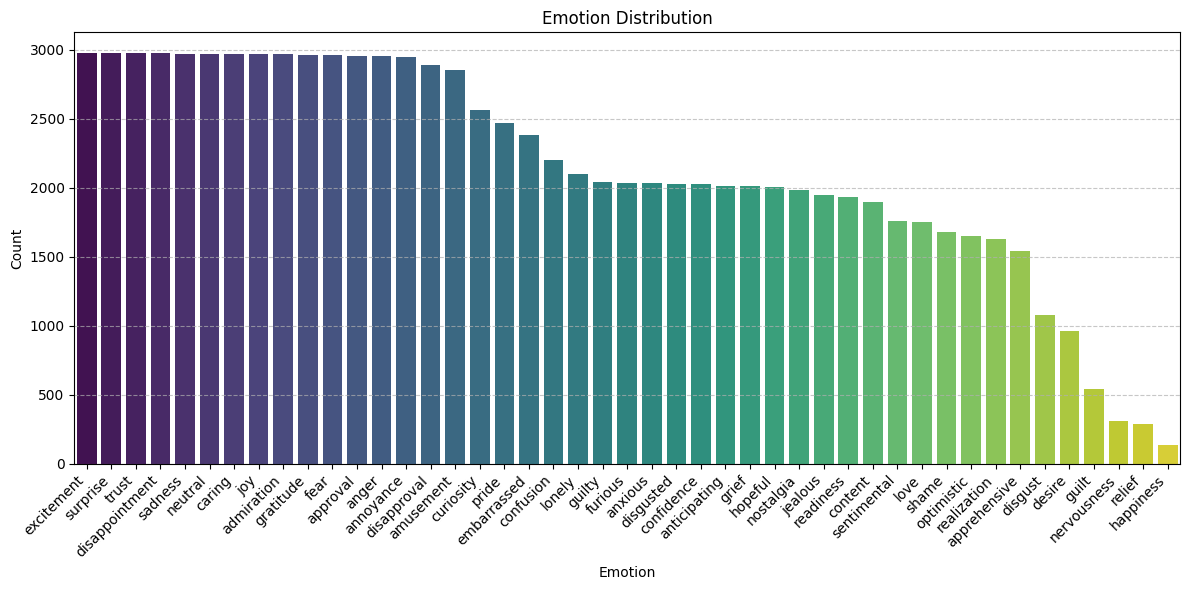

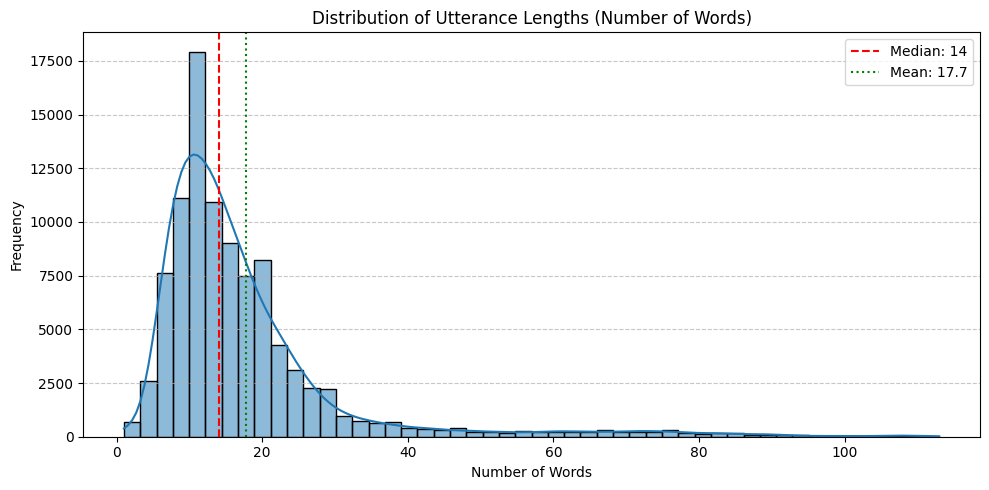


Utterance Length Stats: Min=1, Max=113, Median=14, Mean=17.7
Recommendation: Based on max length 113, increasing MAX_LENGTH to 256 seems reasonable if resources allow. Current MAX_LENGTH is 256.


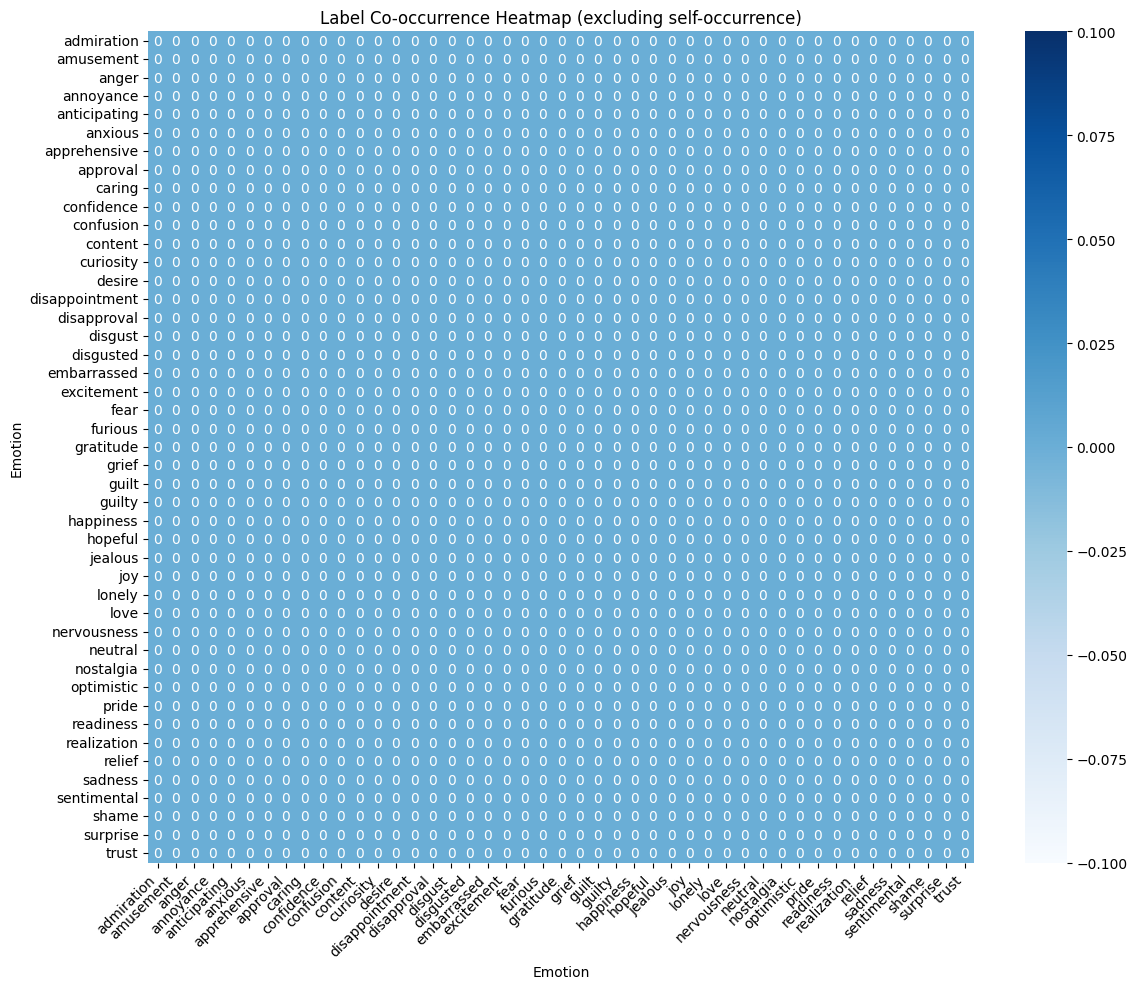


Analyzing VAD feature distribution per emotion (might take a moment)...


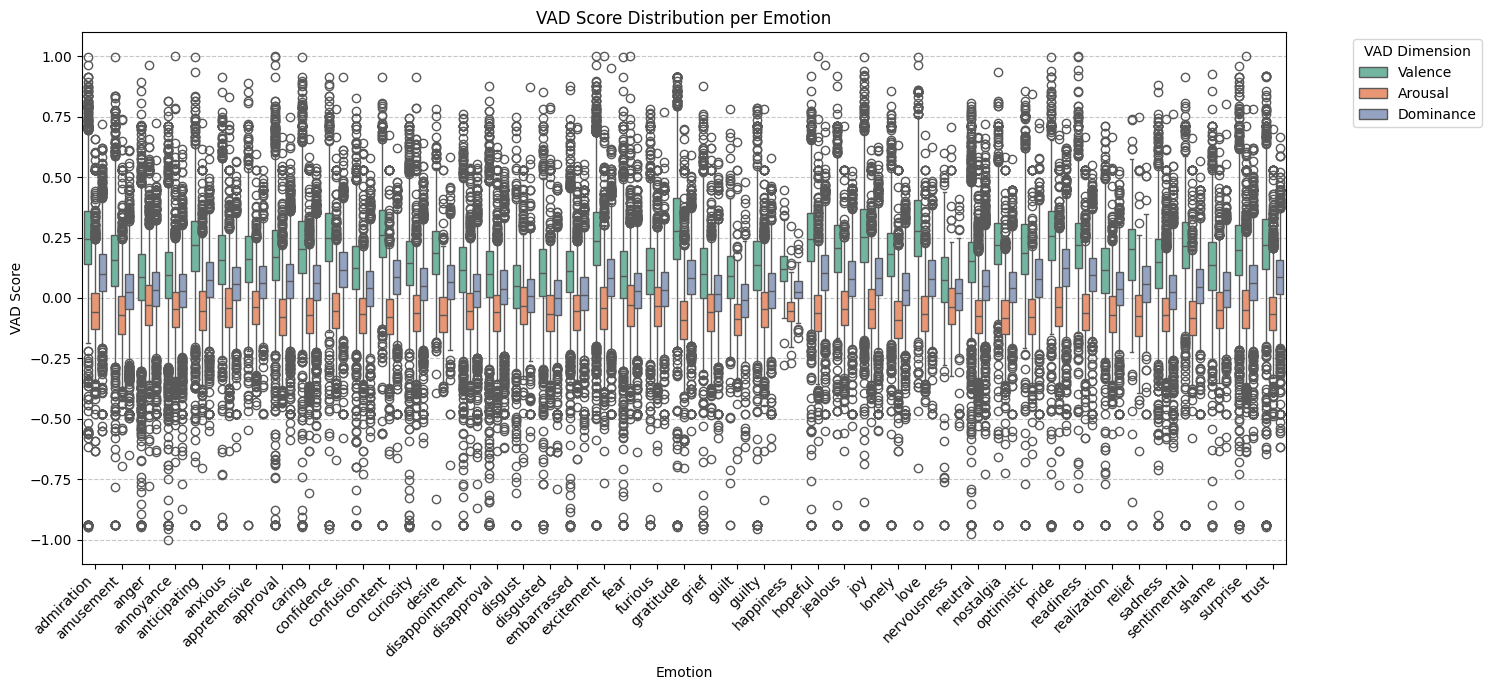


--- End EDA ---


In [7]:
# --- Exploratory Data Analysis (EDA) ---
print("\n--- EDA ---")
print(f"Total samples in dataset: {len(balanced_df)}")

# 1. Emotion Distribution (Original)
all_emotions = [emo for sublist in balanced_df['emotion'] for emo in sublist if sublist] # Check if sublist is not empty
emotion_counts = Counter(all_emotions)
emotion_counts_df = pd.DataFrame.from_dict(emotion_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)

print("\nEmotion distribution:")
print(emotion_counts_df)

plt.figure(figsize=(12, 6))
sns.barplot(x=emotion_counts_df.index, y=emotion_counts_df['Count'], palette="viridis")
plt.title("Emotion Distribution")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(Path(config.OUTPUT_DIR) / "emotion_distribution.png")
plt.show()

# 2. Utterance Length Distribution (New EDA)
balanced_df['utterance_length'] = balanced_df['utterance'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(balanced_df['utterance_length'], bins=50, kde=True)
plt.title("Distribution of Utterance Lengths (Number of Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
median_len = balanced_df['utterance_length'].median()
mean_len = balanced_df['utterance_length'].mean()
plt.axvline(median_len, color='r', linestyle='--', label=f'Median: {median_len:.0f}')
plt.axvline(mean_len, color='g', linestyle=':', label=f'Mean: {mean_len:.1f}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(Path(config.OUTPUT_DIR) / "utterance_length_distribution.png")
plt.show()
print(f"\nUtterance Length Stats: Min={balanced_df['utterance_length'].min()}, Max={balanced_df['utterance_length'].max()}, Median={median_len:.0f}, Mean={mean_len:.1f}")
print(f"Recommendation: Based on max length {balanced_df['utterance_length'].max()}, increasing MAX_LENGTH to 256 seems reasonable if resources allow. Current MAX_LENGTH is {config.MAX_LENGTH}.")


# 3. Label Co-occurrence Heatmap (New EDA)
# Calculate co-occurrence matrix
co_occurrence_matrix = np.dot(labels.T, labels)
# Normalize diagonal to zero for better visualization of off-diagonal elements
np.fill_diagonal(co_occurrence_matrix, 0)
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=label_names, columns=label_names)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt="d", cmap="Blues")
plt.title("Label Co-occurrence Heatmap (excluding self-occurrence)")
plt.xlabel("Emotion")
plt.ylabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(Path(config.OUTPUT_DIR) / "label_cooccurrence.png")
plt.show()

# 4. VAD Feature Distribution per Emotion (New EDA)
print("\nAnalyzing VAD feature distribution per emotion (might take a moment)...")
vad_df = pd.DataFrame(vad_features, columns=['Valence', 'Arousal', 'Dominance'])
emotion_vad_data = []
for i, emotion in enumerate(label_names):
    # Get indices where this emotion is present
    emotion_indices = np.where(labels[:, i] == 1)[0]
    if len(emotion_indices) > 0:
        emotion_vad_scores = vad_df.iloc[emotion_indices]
        for vad_dim in ['Valence', 'Arousal', 'Dominance']:
            for score in emotion_vad_scores[vad_dim]:
                 # Check for NaN before appending
                 if not math.isnan(score):
                    emotion_vad_data.append({'Emotion': emotion, 'VAD_Dimension': vad_dim, 'Score': score})

if emotion_vad_data: # Check if list is not empty
    emotion_vad_df = pd.DataFrame(emotion_vad_data)
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='Emotion', y='Score', hue='VAD_Dimension', data=emotion_vad_df, palette="Set2")
    plt.title("VAD Score Distribution per Emotion")
    plt.xlabel("Emotion")
    plt.ylabel("VAD Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='VAD Dimension', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(Path(config.OUTPUT_DIR) / "vad_per_emotion.png")
    plt.show()
else:
    print("Could not generate VAD per emotion plot (likely no VAD scores found).")

print("\n--- End EDA ---")


In [8]:
# --- Data Splitting (Stratified) ---
print("\nSplitting data...")
X = np.array(utterances)
y = labels
vad = vad_features # Use the full vad_features array

# Using MultilabelStratifiedKFold for robust splitting
mskf = MultilabelStratifiedKFold(n_splits=config.N_SPLITS, shuffle=True, random_state=config.RANDOM_STATE)
# This ensures stratification across all three sets more reliably than a double split
fold_indices = list(mskf.split(X, y))
train_idx, temp_idx = fold_indices[0] # Use first fold for initial split
X_train, y_train, vad_train = X[train_idx], y[train_idx], vad[train_idx]
X_temp, y_temp, vad_temp = X[temp_idx], y[temp_idx], vad[temp_idx]

# We will split indices to keep alignment with VAD features
temp_indices_range = np.arange(len(X_temp))
# Approximate split: 50% validation, 50% test from the temp set
val_size = len(temp_indices_range) // 2
test_size = len(temp_indices_range) - val_size # Ensure all samples are used

# Simple split of indices - less ideal than stratification, but practical here.
# For better stratification, one could use skmultilearn's iterative_train_test_split on temp data.
np.random.shuffle(temp_indices_range) # Shuffle indices before splitting
val_idx_rel = temp_indices_range[:val_size]
test_idx_rel = temp_indices_range[val_size:]

# Map relative indices back to the original 'temp' data
X_val, y_val, vad_val = X_temp[val_idx_rel], y_temp[val_idx_rel], vad_temp[val_idx_rel]
X_test, y_test, vad_test = X_temp[test_idx_rel], y_temp[test_idx_rel], vad_temp[test_idx_rel]


print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# --- Check Label Distribution in Splits (Important for low-count emotions) ---
print("\nLabel distribution in splits:")
print("Train:", np.sum(y_train, axis=0))
print("Val:", np.sum(y_val, axis=0))
print("Test:", np.sum(y_test, axis=0))
# Verify that all labels have non-zero counts in all splits, especially validation and test.



Splitting data...
Train set size: 77041
Validation set size: 9630
Test set size: 9631

Label distribution in splits:
Train: [2374 2285 2366 2357 1612 1626 1235 2367 2376 1621 1761 1518 2050  771
 2382 2315  860 1622 1906 2383 2372 1626 2372 1612  431 1636  108 1607
 1557 2375 1678 1400  246 2377 1588 1319 1976 1544 1302  231 2379 1411
 1344 2382 2381]
Val: [289 270 305 302 205 194 154 291 296 205 252 197 248 103 305 279 114 203
 233 294 269 207 279 196  61 219  14 181 196 286 202 189  32 287 216 174
 247 187 163  29 324 171 175 296 291]
Test: [305 302 286 287 199 212 155 301 298 200 188 182 265  90 290 300 101 202
 243 302 324 199 314 207  46 190  14 221 193 308 218 161  30 307 181 156
 247 200 162  28 270 181 161 300 305]


In [9]:
# --- Dataset and DataLoader ---
print("\nSetting up Dataset and DataLoaders...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, texts: list, vad_feats: np.ndarray, labels: np.ndarray, tokenizer, max_len: int):
        """
        PyTorch Dataset for emotion classification.

        Args:
            texts (list): List of utterance strings.
            vad_feats (np.ndarray): Array of VAD features.
            labels (np.ndarray): Binarized label array.
            tokenizer: Hugging Face tokenizer instance.
            max_len (int): Maximum sequence length for padding/truncation.
        """
        self.texts = texts
        self.vad_feats = vad_feats
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> dict:
        text = self.texts[idx]
        vad = self.vad_feats[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True, # Add [CLS] and [SEP]
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt" # Return PyTorch tensors
        )

        # Remove the batch dimension added by return_tensors="pt"
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['vad'] = torch.tensor(vad, dtype=torch.float)
        item['labels'] = torch.tensor(label, dtype=torch.float)

        return item


Setting up Dataset and DataLoaders...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
# Create datasets
train_dataset = EmotionDataset(X_train, vad_train, y_train, tokenizer, config.MAX_LENGTH)
val_dataset = EmotionDataset(X_val, vad_val, y_val, tokenizer, config.MAX_LENGTH)
test_dataset = EmotionDataset(X_test, vad_test, y_test, tokenizer, config.MAX_LENGTH)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [11]:
# --- Model Definition ---
class SBERTClassifier(nn.Module):
    """
    Sentence-BERT based classifier with VAD feature concatenation.
    """
    def __init__(self, model_name: str, num_labels: int, dropout_rate: float):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        #     param.requires_grad = False
        self.dropout = nn.Dropout(dropout_rate)
        # Input size = SBERT hidden size + VAD features (3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size + 3, num_labels)

    def forward(self, input_ids, attention_mask, vad):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token embedding
        cls_output = outputs.last_hidden_state[:, 0, :]
        # Concatenate [CLS] embedding with VAD features
        combined = torch.cat((cls_output, vad), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

# --- Loss Function (Weighted) ---

epsilon = 1e-6 # To avoid division by zero if a class has 0 positive samples in train
pos_counts = np.sum(y_train, axis=0)
neg_counts = len(y_train) - pos_counts
pos_weights = neg_counts / (pos_counts + epsilon)

# Ensure weights are reasonable (e.g., clamp if necessary)
# pos_weights = np.clip(pos_weights, 1, 10) # Optional clamping

pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float)
print(f"\nCalculated positive weights for loss function: {pos_weights_tensor.numpy()}")

# Initialize weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)


# --- Training Setup ---
print("\nSetting up training...")
accelerator = Accelerator()
device = accelerator.device # Accelerator handles device placement

model = SBERTClassifier(config.MODEL_NAME, num_labels, config.DROPOUT_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

# Move criterion weights to the correct device
criterion.pos_weight = criterion.pos_weight.to(device)

# Prepare with Accelerator
model, optimizer, train_loader, val_loader, test_loader, criterion = accelerator.prepare(
    model, optimizer, train_loader, val_loader, test_loader, criterion
)



Calculated positive weights for loss function: [ 31.45198   32.715973  31.561708  31.68604   46.792183  46.380688
  61.38138   31.54795   31.424664  46.526836  42.74844   49.751648
  36.580975  98.92348   31.342989  32.27905   88.58256   46.497536
  39.42025   31.329416  31.479342  46.380688  31.479342  46.792183
 177.74942   46.091076 712.3426    46.940884  48.48041   31.438316
  44.912395  54.029285 312.1748    31.411022  47.514484  57.40864
  37.98836   48.897022  58.171276 332.51083   31.383774  53.600285
  56.322174  31.342989  31.356573]

Setting up training...


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [12]:
# --- Training Loop ---
print("\nStarting training...")
train_losses, val_losses, val_f1_macros = [], [], [] # Track macro F1 for validation
best_val_metric = -1 # Initialize with -1 for F1-score

for epoch in range(config.NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{config.NUM_EPOCHS}", leave=False)
    for batch in train_progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'] # Already on device via accelerator.prepare
        attention_mask = batch['attention_mask']
        vad = batch['vad'] # Already on device
        labels = batch['labels'] # Already on device

        logits = model(input_ids, attention_mask, vad)
        loss = criterion(logits, labels)

        accelerator.backward(loss)
        optimizer.step()
        total_train_loss += loss.item()
        train_progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

 # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    all_val_preds, all_val_labels = [], []
    val_progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{config.NUM_EPOCHS}", leave=False)
    with torch.no_grad():
        for batch in val_progress_bar:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            vad = batch['vad']
            labels = batch['labels']

            logits = model(input_ids, attention_mask, vad)
            loss = criterion(logits, labels) # Use the same weighted loss for consistency
            total_val_loss += loss.item()

            # Collect predictions and labels across all devices
            preds = torch.sigmoid(logits)
            gathered_preds = accelerator.gather(preds)
            gathered_labels = accelerator.gather(labels)

            all_val_preds.append(gathered_preds.cpu().numpy())
            all_val_labels.append(gathered_labels.cpu().numpy())

            val_progress_bar.set_postfix({'loss': loss.item()})

    avg_val_loss = total_val_loss / len(val_loader) # Note: this might not be perfectly accurate with gather, but gives a trend
    val_losses.append(avg_val_loss)
 # --- Calculate Validation Metrics on Main Process ---
    if accelerator.is_main_process:
        all_val_preds = np.vstack(all_val_preds)
        all_val_labels = np.vstack(all_val_labels).astype(int) # Ensure integer type for metrics
        val_preds_binary = (all_val_preds > config.THRESHOLD).astype(int)

        # Calculate Macro F1-score for validation, handling zero division
        val_f1_macro = f1_score(all_val_labels, val_preds_binary, average='macro', zero_division=0)
        val_f1_macros.append(val_f1_macro)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Macro F1: {val_f1_macro:.4f}")

        # Save model based on best validation Macro F1
        if val_f1_macro > best_val_metric:
            best_val_metric = val_f1_macro
            print(f"*** New best validation Macro F1 found: {best_val_metric:.4f}. Saving model... ***")
            accelerator.wait_for_everyone() # Ensure all processes are ready before saving
            unwrapped_model = accelerator.unwrap_model(model)
            # Save model state dictionary
            torch.save(unwrapped_model.state_dict(), Path(config.CHECKPOINT_DIR) / "pytorch_model.bin")
            # Save tokenizer
            tokenizer.save_pretrained(config.CHECKPOINT_DIR)
            # Save MultiLabelBinarizer classes (needed for loading)
            np.save(Path(config.CHECKPOINT_DIR) / "classes.npy", mlb.classes_)
            print(f"Model saved to {config.CHECKPOINT_DIR}")

# Wait for all processes to finish before proceeding
accelerator.wait_for_everyone()
print("Training finished.")




Starting training...


Training Epoch 1/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 1/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.0771 | Val Loss: 0.9251 | Val Macro F1: 0.1270
*** New best validation Macro F1 found: 0.1270. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 2/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 2/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.8957 | Val Loss: 0.8675 | Val Macro F1: 0.1452
*** New best validation Macro F1 found: 0.1452. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 3/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 3/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.8187 | Val Loss: 0.8473 | Val Macro F1: 0.1516
*** New best validation Macro F1 found: 0.1516. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 4/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 4/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.7589 | Val Loss: 0.8377 | Val Macro F1: 0.1668
*** New best validation Macro F1 found: 0.1668. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 5/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 5/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.7090 | Val Loss: 0.8562 | Val Macro F1: 0.1706
*** New best validation Macro F1 found: 0.1706. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 6/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 6/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.6663 | Val Loss: 0.8687 | Val Macro F1: 0.1762
*** New best validation Macro F1 found: 0.1762. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 7/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 7/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.6262 | Val Loss: 0.8992 | Val Macro F1: 0.1861
*** New best validation Macro F1 found: 0.1861. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 8/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 8/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.5899 | Val Loss: 0.9250 | Val Macro F1: 0.1888
*** New best validation Macro F1 found: 0.1888. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 9/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 9/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.5574 | Val Loss: 0.9667 | Val Macro F1: 0.1964
*** New best validation Macro F1 found: 0.1964. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 10/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 10/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.5238 | Val Loss: 1.0088 | Val Macro F1: 0.2010
*** New best validation Macro F1 found: 0.2010. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 11/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 11/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.4951 | Val Loss: 1.0508 | Val Macro F1: 0.2018
*** New best validation Macro F1 found: 0.2018. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 12/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 12/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.4685 | Val Loss: 1.0886 | Val Macro F1: 0.2070
*** New best validation Macro F1 found: 0.2070. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 13/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 13/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.4458 | Val Loss: 1.1310 | Val Macro F1: 0.2106
*** New best validation Macro F1 found: 0.2106. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 14/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 14/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.4222 | Val Loss: 1.2111 | Val Macro F1: 0.2153
*** New best validation Macro F1 found: 0.2153. Saving model... ***
Model saved to checkpoints/best_model


Training Epoch 15/15:   0%|          | 0/2408 [00:00<?, ?it/s]

Validation Epoch 15/15:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.4007 | Val Loss: 1.2638 | Val Macro F1: 0.2198
*** New best validation Macro F1 found: 0.2198. Saving model... ***
Model saved to checkpoints/best_model
Training finished.



Plotting training curves...


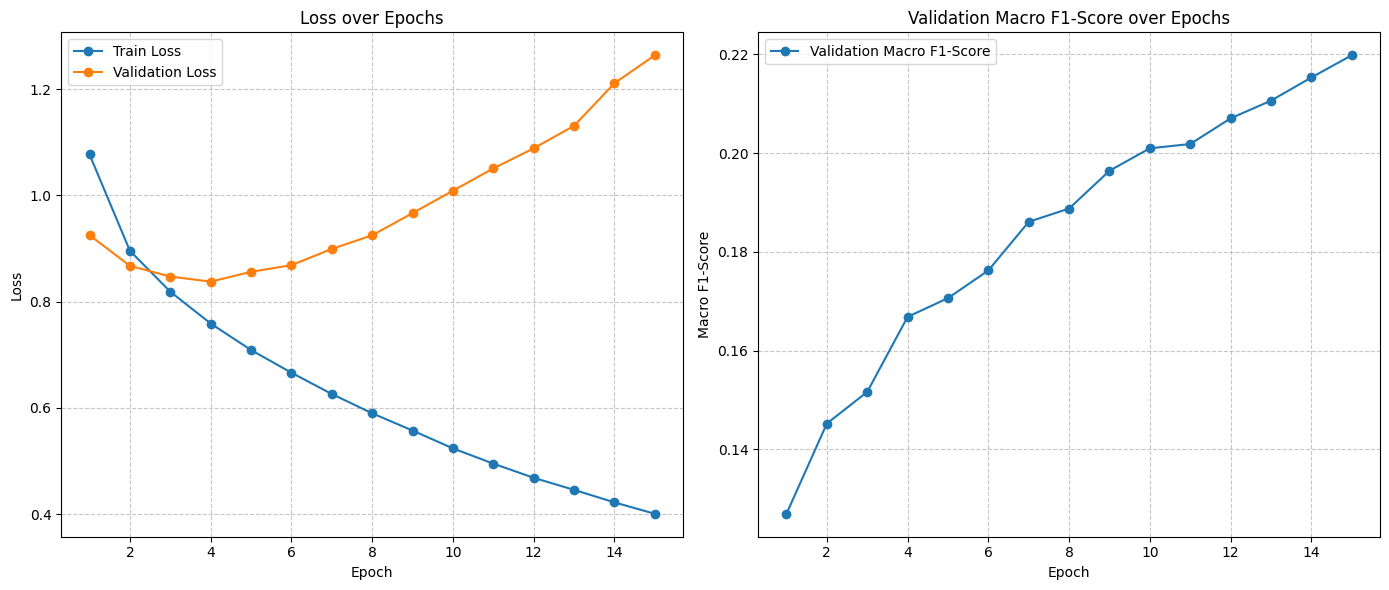

In [13]:
# --- Plot Training Curves ---
if accelerator.is_main_process:
    print("\nPlotting training curves...")
    epochs_range = range(1, config.NUM_EPOCHS + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_f1_macros, 'o-', label='Validation Macro F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1-Score')
    plt.title('Validation Macro F1-Score over Epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(Path(config.OUTPUT_DIR) / "training_curves.png")
    plt.show()


In [14]:
# --- Load Best Model for Evaluation ---
# Address point 1: Re-initializer / Loading the trained model
print("\nLoading the best model for evaluation...")
# Load tokenizer
eval_tokenizer = AutoTokenizer.from_pretrained(config.CHECKPOINT_DIR)

# Load label names
eval_label_names = np.load(Path(config.CHECKPOINT_DIR) / "classes.npy", allow_pickle=True)
eval_num_labels = len(eval_label_names)

# Instantiate the model architecture
eval_model = SBERTClassifier(config.MODEL_NAME, eval_num_labels, config.DROPOUT_RATE)

# Load the saved state dictionary
model_path = Path(config.CHECKPOINT_DIR) / "pytorch_model.bin"
if model_path.exists():
    state_dict = torch.load(model_path, map_location=accelerator.device) # Load to appropriate device
    eval_model.load_state_dict(state_dict)
    print(f"Model weights loaded successfully from {model_path}")
else:
    print(f"ERROR: Model file not found at {model_path}. Cannot evaluate.")
    # Handle error appropriately

# Prepare the loaded model with Accelerator (important for multi-GPU inference)
eval_model = accelerator.prepare(eval_model)
eval_model.eval() # Set to evaluation mode



Loading the best model for evaluation...
Model weights loaded successfully from checkpoints/best_model/pytorch_model.bin


SBERTClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementw


Evaluating on the test set...


Testing:   0%|          | 0/301 [00:00<?, ?it/s]


Classification Report (Test Set):
                precision    recall  f1-score   support

    admiration       0.15      0.70      0.24       305
     amusement       0.29      0.82      0.42       302
         anger       0.12      0.67      0.20       286
     annoyance       0.10      0.62      0.17       287
  anticipating       0.10      0.71      0.17       199
       anxious       0.09      0.68      0.16       212
  apprehensive       0.09      0.60      0.16       155
      approval       0.11      0.55      0.18       301
        caring       0.14      0.63      0.23       298
    confidence       0.11      0.72      0.19       200
     confusion       0.14      0.72      0.23       188
       content       0.12      0.64      0.20       182
     curiosity       0.19      0.65      0.29       265
        desire       0.11      0.53      0.18        90
disappointment       0.09      0.60      0.16       290
   disapproval       0.16      0.72      0.27       300
       disgu

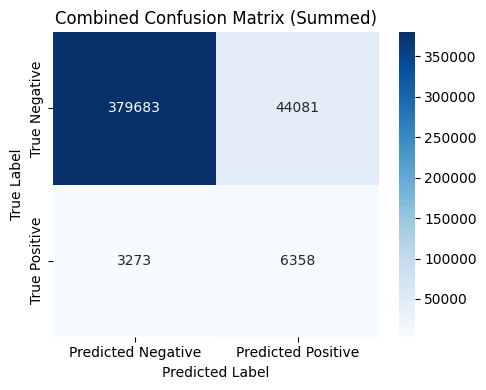

Note: This 'combined' matrix sums counts across all labels. Interpret with caution, as it aggregates diverse label performances.


In [15]:
# --- Evaluation on Test Set ---
print("\nEvaluating on the test set...")
all_test_preds, all_test_labels = [], []

# Ensure test_loader is prepared if not done during training prep
prepared_test_loader = accelerator.prepare(test_loader) # Re-prepare if needed

with torch.no_grad():
    test_progress_bar = tqdm(prepared_test_loader, desc="Testing", leave=False)
    for batch in test_progress_bar:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        vad = batch['vad']
        labels = batch['labels']

        # Use the loaded eval_model
        logits = eval_model(input_ids, attention_mask, vad)
        preds = torch.sigmoid(logits)

        # Gather results from all processes
        gathered_preds = accelerator.gather(preds)
        gathered_labels = accelerator.gather(labels)

        all_test_preds.append(gathered_preds.cpu().numpy())
        all_test_labels.append(gathered_labels.cpu().numpy())

# Process results on the main process
if accelerator.is_main_process:
    y_true = np.vstack(all_test_labels).astype(int)
    y_pred_probs = np.vstack(all_test_preds)
    y_pred = (y_pred_probs > config.THRESHOLD).astype(int)

    # --- Classification Report ---
    print("\nClassification Report (Test Set):")
    # Use output_dict=True for easier parsing if needed later
    report = classification_report(y_true, y_pred, target_names=eval_label_names, zero_division=0, output_dict=False)
    report_dict = classification_report(y_true, y_pred, target_names=eval_label_names, zero_division=0, output_dict=True)
    print(report)
    # Save report to file
    with open(Path(config.OUTPUT_DIR) / "classification_report.txt", "w") as f:
        f.write(report)
    pd.DataFrame(report_dict).transpose().to_csv(Path(config.OUTPUT_DIR) / "classification_report.csv")


    # --- Combined Confusion Matrix (Summation Approach) ---
    # Calculate summed TP, FP, FN, TN across all labels
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    # mcm gives [[TN, FP], [FN, TP]] for each label
    total_tn = np.sum(mcm[:, 0, 0])
    total_fp = np.sum(mcm[:, 0, 1])
    total_fn = np.sum(mcm[:, 1, 0])
    total_tp = np.sum(mcm[:, 1, 1])

    # Create the combined 2x2 matrix
    combined_cm = np.array([[total_tn, total_fp],
                            [total_fn, total_tp]])

    print("\nCombined Confusion Matrix (Summed across labels):")
    print(f"[[TN={total_tn}, FP={total_fp}]")
    print(f" [FN={total_fn}, TP={total_tp}]]")

    plt.figure(figsize=(5, 4))
    sns.heatmap(combined_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["True Negative", "True Positive"])
    plt.title("Combined Confusion Matrix (Summed)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(Path(config.OUTPUT_DIR) / "combined_confusion_matrix.png")
    plt.show()
    print("Note: This 'combined' matrix sums counts across all labels. Interpret with caution, as it aggregates diverse label performances.")


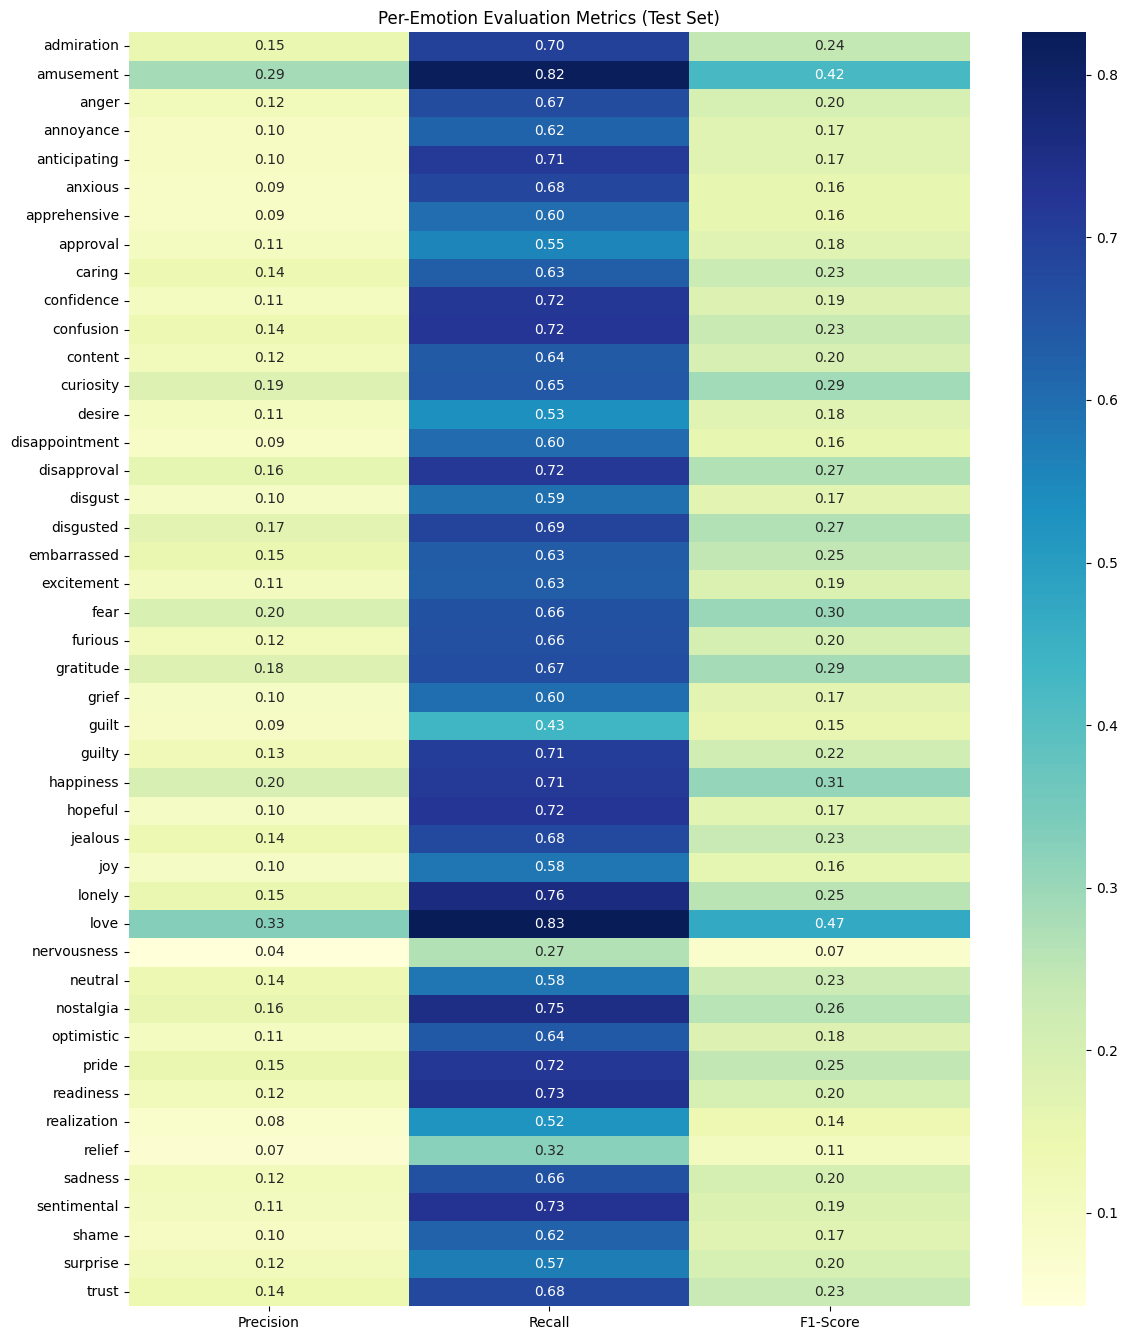

Evaluation plots saved to outputs/evaluation_plots.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# --- Per-Emotion Metrics Heatmap ---
# (Your original code for this is good, kept for detailed view)
if accelerator.is_main_process: # Added indentation to place the per-emotion metric calculation inside the if block.
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    metrics_df = pd.DataFrame({
        "Precision": precision_per_class,
        "Recall": recall_per_class,
        "F1-Score": f1_per_class
    }, index=eval_label_names)

    plt.figure(figsize=(12, max(6, len(eval_label_names) * 0.3))) # Adjust height based on number of labels
    sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Per-Emotion Evaluation Metrics (Test Set)")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(Path(config.OUTPUT_DIR) / "per_emotion_metrics_heatmap.png")
    plt.show()


    # --- Save Individual Confusion Matrices to PDF ---
    # (Your original code is good, just updating paths)
    pdf_path = Path(config.OUTPUT_DIR) / config.PDF_FILENAME
    with PdfPages(pdf_path) as pdf:
        # Plot Combined CM first
        fig_comb = plt.figure(figsize=(5, 4))
        sns.heatmap(combined_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Predicted Negative", "Predicted Positive"],
                    yticklabels=["True Negative", "True Positive"])
        plt.title("Combined Confusion Matrix (Summed)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        pdf.savefig(fig_comb)
        plt.close(fig_comb)

        # Plot Per-Emotion Metrics Heatmap
        fig_metrics = plt.figure(figsize=(12, max(6, len(eval_label_names) * 0.3)))
        sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Per-Emotion Evaluation Metrics (Test Set)")
        plt.yticks(rotation=0)
        plt.tight_layout()
        pdf.savefig(fig_metrics)
        plt.close(fig_metrics)

        # Plot Individual CMs
        for idx, label in enumerate(eval_label_names):
            cm = mcm[idx] # Get the matrix for this label
            fig_indiv = plt.figure(figsize=(4, 4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=[f"Not '{label}'", f"'{label}'"],
                        yticklabels=[f"Not '{label}'", f"'{label}'"])
            plt.title(f"Confusion Matrix for '{label}'")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.tight_layout()
            pdf.savefig(fig_indiv)
            plt.close(fig_indiv)

    print(f"Evaluation plots saved to {pdf_path}")
    # Optional download for Colab
    files.download(str(pdf_path))

In [19]:
# --- Prediction Function ---

def predict_emotions(text: str, model, tokenizer, vad_lexicon, label_names, device, max_len: int, threshold: float = 0.5, pretty_print: bool = False, show_table: bool = False):
    """
    Predicts emotions for a given text using the trained model.

    Args:
        text (str): The input text utterance.
        model: The trained SBERTClassifier model (already on the correct device).
        tokenizer: The corresponding Hugging Face tokenizer.
        vad_lexicon: The NRC-VAD lexicon DataFrame.
        label_names (list): List of emotion label names.
        device: The torch device to run inference on.
        max_len (int): Max sequence length for tokenization.
        threshold (float): Probability threshold for classifying an emotion as present.
        pretty_print (bool): Whether to print the output nicely formatted.
        show_table (bool): Whether to display the top 5 emotions as a table (requires IPython/Jupyter).

    Returns:
        dict: A dictionary containing predicted emotions (> threshold) and top 5 probabilities.
    """
    model.eval() # Ensure model is in eval mode

    # Compute NRC-VAD features
    # Use the same function as in preprocessing for consistency
    vad_feat_np = compute_vad_features(text, vad_lexicon)
    vad_feat = torch.tensor(vad_feat_np, dtype=torch.float32).unsqueeze(0).to(device)

    # Tokenize the text
    encoding = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length", # Pad to max_length for consistent input size
        max_length=max_len
    ).to(device)

    # Run inference
    with torch.no_grad():
        logits = model(encoding['input_ids'], encoding['attention_mask'], vad_feat)
        probs = torch.sigmoid(logits).squeeze(0).cpu().numpy() # Get probabilities for the single input

    # Emotions with probability > threshold
    predicted_indices = np.where(probs > threshold)[0]
    predicted_emotions_dict = {
        label_names[i]: float(probs[i])
        for i in predicted_indices
    }

    # Top 5 probable emotions regardless of threshold
    top_5_indices = probs.argsort()[-5:][::-1] # Get indices of top 5 probabilities
    top_5_emotions_list = [
        {"Emotion": label_names[i], "Probability": round(float(probs[i]), 4)}
        for i in top_5_indices
    ]

    result = {
        "input_text": text,
        "predicted_emotions": predicted_emotions_dict,
        "top_5_probabilities": top_5_emotions_list
    }

    if pretty_print:
        print(json.dumps(result, indent=4))

    if show_table:
        try:
            from IPython.display import display
            df = pd.DataFrame(top_5_emotions_list)
            print("\nTop 5 Probable Emotions:")
            display(df)
        except ImportError:
            print("Cannot display table. IPython is not available.")
            print(top_5_emotions_list) # Fallback to printing the list


    return result

In [20]:
# --- Example Prediction (using the loaded model) ---
if accelerator.is_main_process:
    print("\nExample Prediction:")
    example_text = "Though I smiled and congratulated her on the promotion, deep down I couldn't shake the bitter sting of being overlooked once again — a mix of admiration, envy, and quiet despair churned within me."
    prediction_result = predict_emotions(
        text=example_text,
        model=eval_model,
        tokenizer=eval_tokenizer,
        vad_lexicon=nrc_vad,
        label_names=eval_label_names,
        device=accelerator.device,
        max_len=config.MAX_LENGTH,
        threshold=config.THRESHOLD,
        pretty_print=False,
        show_table=True
    )


Example Prediction:

Top 5 Probable Emotions:


,Emotion,Probability
0,disappointment,0.8934
1,sadness,0.8741
2,lonely,0.6173
3,grief,0.5197
4,gratitude,0.3745


In [21]:
# --- Example Prediction (using the loaded model) ---
if accelerator.is_main_process:
    print("\nExample Prediction:")
    example_text = "I stopped expecting apologies a long time ago — silence speaks louder, and disappointment eventually becomes routine."
    prediction_result = predict_emotions(
        text=example_text,
        model=eval_model,
        tokenizer=eval_tokenizer,
        vad_lexicon=nrc_vad,
        label_names=eval_label_names,
        device=accelerator.device,
        max_len=config.MAX_LENGTH,
        threshold=config.THRESHOLD,
        pretty_print=False,
        show_table=True
    )


Example Prediction:

Top 5 Probable Emotions:


,Emotion,Probability
0,guilt,0.9796
1,disappointment,0.9662
2,sadness,0.8961
3,grief,0.7815
4,shame,0.5771


In [22]:
# --- Example Prediction (using the loaded model) ---
if accelerator.is_main_process:
    print("\nExample Prediction:")
    example_text = "I woke up to the sound of birds, the sun gently shining through my window, and a heart full of gratitude — today just feels beautifully right."
    prediction_result = predict_emotions(
        text=example_text,
        model=eval_model,
        tokenizer=eval_tokenizer,
        vad_lexicon=nrc_vad,
        label_names=eval_label_names,
        device=accelerator.device,
        max_len=config.MAX_LENGTH,
        threshold=config.THRESHOLD,
        pretty_print=False,
        show_table=True
    )


Example Prediction:

Top 5 Probable Emotions:


,Emotion,Probability
0,gratitude,0.8935
1,caring,0.8399
2,sentimental,0.7324
3,content,0.7030
4,joy,0.5643


In [24]:
# --- Save and Download Final Model ---
if accelerator.is_main_process:
    print("\nZipping the best model checkpoint...")
    # The best model is already saved in config.CHECKPOINT_DIR during training
    zip_path = Path(config.OUTPUT_DIR) / config.MODEL_ZIP_FILENAME
    # Use python's zipfile module for better control
    import zipfile
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        checkpoint_path = Path(config.CHECKPOINT_DIR)
        for file_path in checkpoint_path.rglob('*'):
            zipf.write(file_path, file_path.relative_to(checkpoint_path))
    print(f"Model checkpoint zipped to {zip_path}")

    #  download in Colab
    try: # Fixed indentation here
        files.download(str(zip_path))
        print(f"Initiated download for {config.MODEL_ZIP_FILENAME}")
    except NameError:
        print("Skipping automatic download (not in Colab environment).")



Zipping the best model checkpoint...
Model checkpoint zipped to outputs/best_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initiated download for best_model.zip


# **Re-intialize**

In [52]:
import os
import torch
import json
import numpy as np
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModel

class CustomSBERTClassifier(torch.nn.Module):
    """Modified SBERT-based emotion classifier with VAD features that matches your model structure"""
    def __init__(self, model_name, num_labels, vad_features_dim=3):
        super().__init__()

        # The main difference is here - we're using 'encoder' as the attribute name, not 'sbert'
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size

        # Combined features: SBERT + VAD
        self.classifier = torch.nn.Linear(self.hidden_size + vad_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, vad_features):
        # Get SBERT embeddings using the encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token

        # Concatenate SBERT embeddings with VAD features
        combined_features = torch.cat([pooled_output, vad_features], dim=1)

        # Pass through classifier
        logits = self.classifier(combined_features)
        return logits

def load_vad_lexicon(file_path):
    """Load NRC VAD Lexicon from file with flexible column handling"""
    try:
        # Try to read the file first to examine its structure
        df = pd.read_csv(file_path, sep='\t', header=0)
        print(f"VAD lexicon columns: {df.columns.tolist()}")

        # Set the first column as the index
        df = df.set_index(df.columns[0])

        # Verify we have the expected structure (at least 3 columns for V, A, D)
        if len(df.columns) < 3:
            raise ValueError(f"VAD lexicon has insufficient columns: {df.columns}")

        return df
    except Exception as e:
        raise ValueError(f"Failed to parse VAD lexicon file: {e}. Please check the file format.")

def compute_vad_features(text, vad_lexicon):
    """Compute VAD (Valence, Arousal, Dominance) features for the input text"""
    # Lowercasing and basic tokenization
    words = text.lower().split()

    # Print lexicon columns to debug
    vad_columns = vad_lexicon.columns.tolist()
    print(f"VAD lexicon columns available: {vad_columns}")

    # Initialize VAD scores - use the first three columns whatever they're called
    v_scores, a_scores, d_scores = [], [], []

    # Collect VAD scores for words in the lexicon
    for word in words:
        if word in vad_lexicon.index:
            # Use the first three columns for V, A, D respectively
            v_scores.append(float(vad_lexicon.loc[word, vad_columns[0]]))
            a_scores.append(float(vad_lexicon.loc[word, vad_columns[1]]))
            d_scores.append(float(vad_lexicon.loc[word, vad_columns[2]]))

    # Calculate averages (with fallback to neutral 0.5 if no words found)
    v_avg = sum(v_scores) / len(v_scores) if v_scores else 0.5
    a_avg = sum(a_scores) / len(a_scores) if a_scores else 0.5
    d_avg = sum(d_scores) / len(d_scores) if d_scores else 0.5

    return [v_avg, a_avg, d_avg]

def predict_emotions(text, model, tokenizer, vad_lexicon, label_names, device, max_len=128, threshold=0.5, pretty_print=False, show_table=False):
    """
    Predicts emotions for a given text using the trained model.
    """
    import json
    import numpy as np

    model.eval()  # Ensure model is in eval mode

    # Compute NRC-VAD features
    vad_feat_np = compute_vad_features(text, vad_lexicon)
    vad_feat = torch.tensor(vad_feat_np, dtype=torch.float32).unsqueeze(0).to(device)

    # Tokenize the text
    encoding = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_len
    ).to(device)

    # Run inference
    with torch.no_grad():
        logits = model(encoding['input_ids'], encoding['attention_mask'], vad_feat)
        probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()

    # Emotions with probability > threshold
    predicted_indices = np.where(probs > threshold)[0]
    predicted_emotions_dict = {
        label_names[i]: float(probs[i])
        for i in predicted_indices
    }

    # Top 5 probable emotions regardless of threshold
    top_5_indices = probs.argsort()[-5:][::-1]
    top_5_emotions_list = [
        {"Emotion": label_names[i], "Probability": round(float(probs[i]), 4)}
        for i in top_5_indices
    ]

    result = {
        "input_text": text,
        "predicted_emotions": predicted_emotions_dict,
        "top_5_probabilities": top_5_emotions_list
    }

    if pretty_print:
        print(json.dumps(result, indent=4))

    if show_table:
        try:
            from IPython.display import display
            df = pd.DataFrame(top_5_emotions_list)
            print("\nTop 5 Probable Emotions:")
            display(df)
        except ImportError:
            print("Cannot display table. IPython is not available.")
            print(top_5_emotions_list)

    return result

def reinitialize_from_checkpoint(
    model_dir="best_model",
    vad_lexicon_path="NRC-VAD-Lexicon.txt",
    max_len=128,
    threshold=0.5,
    device=None
):
    """
    Reinitializes the emotion detection model from existing checkpoint files.
    Modified to handle the different model structure with 'encoder' prefix.
    """
    # Set device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    # Convert model_dir to Path
    model_path = Path(model_dir)

    # Check if model directory exists
    if not model_path.exists():
        raise FileNotFoundError(f"Model directory not found: {model_path}")

    # Check required files
    required_files = [
        "pytorch_model.bin",
        "classes.npy"
    ]

    optional_tokenizer_files = [
        "special_tokens_map.json",
        "tokenizer.json",
        "tokenizer_config.json",
        "vocab.txt"
    ]

    missing_files = []
    for file in required_files:
        if not (model_path / file).exists():
            missing_files.append(file)

    if missing_files:
        raise FileNotFoundError(f"Required files not found: {', '.join(missing_files)}")

    # Load emotion labels from classes.npy
    label_names = np.load(model_path / "classes.npy", allow_pickle=True).tolist()
    num_labels = len(label_names)

    # Check if tokenizer files exist in the directory
    has_tokenizer_files = all((model_path / file).exists() for file in optional_tokenizer_files)

    # Load tokenizer - either from saved files or default
    if has_tokenizer_files:
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            print("Loaded tokenizer from saved files")
        except Exception as e:
            print(f"Error loading tokenizer from files: {e}")
            print("Falling back to default tokenizer")
            tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
    else:
        print("Tokenizer files not found, using default")
        tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    # Determine the base model name
    model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Default
    if (model_path / "tokenizer_config.json").exists():
        try:
            with open(model_path / "tokenizer_config.json", "r") as f:
                tokenizer_config = json.load(f)
            config_model_name = tokenizer_config.get("name_or_path")
            if config_model_name:
                model_name = config_model_name
        except Exception as e:
            print(f"Error reading tokenizer config: {e}")

    # Initialize model architecture with modified class
    model = CustomSBERTClassifier(
        model_name=model_name,
        num_labels=num_labels,
        vad_features_dim=3
    )

    # Load saved model weights
    try:
        state_dict = torch.load(model_path / "pytorch_model.bin", map_location=device)
        model.load_state_dict(state_dict)
        print("Model weights loaded successfully")
    except Exception as e:
        print(f"Error loading state dict directly: {e}")
        print("Attempting to fix state dict keys...")

        # Load state dict and modify keys if needed
        state_dict = torch.load(model_path / "pytorch_model.bin", map_location=device)

        # Check if we need to apply any key transformations
        sample_keys = list(state_dict.keys())[:5]
        print(f"Sample keys in saved model: {sample_keys}")

        # Create a new state dict with correct keys if needed
        new_state_dict = {}
        for key, value in state_dict.items():
            # Handle possible key patterns
            if key.startswith('encoder.'):
                # Expected pattern for our CustomSBERTClassifier
                new_key = key
            elif key.startswith('sbert.'):
                # Convert sbert.* to encoder.*
                new_key = key.replace('sbert.', 'encoder.')
            else:
                # Keep as is for other keys (like classifier)
                new_key = key

            new_state_dict[new_key] = value

        # Try loading with the modified state dict
        try:
            model.load_state_dict(new_state_dict)
            print("Model loaded successfully with modified state dict")
        except Exception as nested_e:
            print(f"Error loading with modified keys: {nested_e}")
            print("\nModel key structure might be different. Attempting to create a compatible model...")

            # As a last resort, create a model that matches the state dict structure
            class_keys = [k for k in state_dict.keys() if 'classifier' in k]
            if class_keys:
                print(f"Found classifier keys: {class_keys}")
            else:
                print("No classifier keys found in state dict")

            # This part might need customization based on the exact model structure
            input_dim = None
            output_dim = None

            if len(class_keys) > 0:
                classifier_weight_key = [k for k in class_keys if 'weight' in k]
                if classifier_weight_key:
                    weight_shape = state_dict[classifier_weight_key[0]].shape
                    input_dim = weight_shape[0]
                    output_dim = weight_shape[1]
                    print(f"Detected classifier dimensions: input={input_dim}, output={output_dim}")

            # Create a minimal model that just loads the classifier weights
            # This is a fallback that might work if the SBERT part is missing or incompatible
            if input_dim is not None and output_dim is not None:
                class MinimalModel(torch.nn.Module):
                    def __init__(self, input_dim, output_dim):
                        super().__init__()
                        self.classifier = torch.nn.Linear(input_dim, output_dim)

                    def forward(self, input_ids, attention_mask, vad_features):
                        # This is just a placeholder implementation
                        # It won't work correctly but allows loading the weights
                        return self.classifier(torch.zeros(1, input_dim).to(input_ids.device))

                model = MinimalModel(input_dim, output_dim)
                try:
                    # Try to load just the classifier weights
                    classifier_dict = {k: v for k, v in state_dict.items() if 'classifier' in k}
                    model.load_state_dict(classifier_dict, strict=False)
                    print("Warning: Only classifier weights loaded. Model may not function correctly.")
                except Exception as e3:
                    print(f"Failed to load even minimal model: {e3}")
                    raise RuntimeError("Could not load the model with any method. Model structure might be incompatible.")
            else:
                raise RuntimeError("Could not determine model dimensions from state dict")

    model.to(device)
    model.eval()

    # Load VAD lexicon with more detailed debugging
    try:
        print(f"Attempting to load VAD lexicon from {vad_lexicon_path}")
        vad_lexicon = load_vad_lexicon(vad_lexicon_path)
    except Exception as e:
        print(f"Error loading VAD lexicon from {vad_lexicon_path}: {e}")
        # Try to find it in the model directory
        alternative_path = model_path / "NRC-VAD-Lexicon.txt"
        print(f"Trying alternative path: {alternative_path}")
        if alternative_path.exists():
            try:
                vad_lexicon = load_vad_lexicon(alternative_path)
            except Exception as e2:
                print(f"Error loading from alternative path: {e2}")
                raise
        else:
            print(f"VAD lexicon not found at alternative path: {alternative_path}")
            raise FileNotFoundError(
                f"VAD lexicon not found at {vad_lexicon_path} or {alternative_path}. "
                "Please download it from http://saifmohammad.com/WebPages/nrc-vad.html"
            )

    # Create config dictionary for convenience
    config = {
        "model_dir": str(model_path),
        "max_length": max_len,
        "threshold": threshold,
        "device": device,
        "num_emotions": num_labels
    }

    print(f"Emotion detection model successfully loaded from {model_path}")
    print(f"Model contains {num_labels} emotion labels: {', '.join(label_names[:5])}{'...' if len(label_names) > 5 else ''}")
    print(f"Using threshold: {threshold}")
    print(f"Running on device: {device}")

    return model, tokenizer, vad_lexicon, label_names, config

def extract_model_zip(zip_path, extract_dir=None, overwrite=False):
    """
    Extract the model zip file to the specified directory.

    Args:
        zip_path (str): Path to the zip file containing model files
        extract_dir (str, optional): Directory to extract files to. If None, extracts to a directory named after the zip file
        overwrite (bool): Whether to overwrite existing files

    Returns:
        str: Path to the extracted directory
    """
    import zipfile
    import shutil

    zip_path = Path(zip_path)

    # If no extract_dir specified, use the zip filename without extension
    if extract_dir is None:
        extract_dir = zip_path.stem

    extract_path = Path(extract_dir)

    # Check if directory already exists
    if extract_path.exists():
        if overwrite:
            print(f"Removing existing directory: {extract_path}")
            shutil.rmtree(extract_path)
        else:
            print(f"Directory already exists: {extract_path}")
            return str(extract_path)

    # Create extraction directory
    extract_path.mkdir(parents=True, exist_ok=True)

    # Extract files
    print(f"Extracting {zip_path} to {extract_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Check if files are nested in a subdirectory
    contents = list(extract_path.iterdir())
    if len(contents) == 1 and contents[0].is_dir():
        # If there's only one subdirectory, move its contents up
        subdir = contents[0]
        for item in subdir.iterdir():
            # Move each item to the parent directory
            shutil.move(str(item), str(extract_path))
        # Remove the now-empty subdirectory
        subdir.rmdir()

    return str(extract_path)

def initialize_emotion_model(
    model_zip_path="best_model.zip",
    vad_lexicon_path="NRC-VAD-Lexicon.txt",
    extract_dir=None,
    overwrite_extract=False,
    max_len=128,
    threshold=0.5,
    device=None
):
    """
    Complete function to extract and initialize the emotion model in one step.
    """
    import zipfile

    # Check if model_zip_path is a zip file or directory
    model_zip_path = Path(model_zip_path)

    if model_zip_path.is_file() and zipfile.is_zipfile(model_zip_path):
        # Extract the zip file
        model_dir = extract_model_zip(
            zip_path=model_zip_path,
            extract_dir=extract_dir,
            overwrite=overwrite_extract
        )
    else:
        # Use as directory directly
        model_dir = str(model_zip_path)

    # Initialize from the extracted directory
    return reinitialize_from_checkpoint(
        model_dir=model_dir,
        vad_lexicon_path=vad_lexicon_path,
        max_len=max_len,
        threshold=threshold,
        device=device
    )

# Additional function to inspect and debug lexicon format
def inspect_vad_lexicon(file_path):
    """Inspect the format of the VAD lexicon file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Read first few lines
            print("First 5 lines of the lexicon file:")
            for i, line in enumerate(f):
                if i < 5:
                    print(f"Line {i+1}: {line.strip()}")
                else:
                    break

        # Try different parsing approaches
        print("\nAttempting to parse with different methods:")

        # Method 1: Tab-separated with header
        try:
            df1 = pd.read_csv(file_path, sep='\t', header=0)
            print(f"Method 1 (tab-separated with header): Columns = {df1.columns.tolist()}, Shape = {df1.shape}")
        except Exception as e:
            print(f"Method 1 failed: {e}")

        # Method 2: Tab-separated without header
        try:
            df2 = pd.read_csv(file_path, sep='\t', header=None)
            print(f"Method 2 (tab-separated without header): Columns = {df2.columns.tolist()}, Shape = {df2.shape}")
        except Exception as e:
            print(f"Method 2 failed: {e}")

        # Method 3: Auto-detect separator
        try:
            df3 = pd.read_csv(file_path, sep=None, engine='python')
            print(f"Method 3 (auto-detect separator): Columns = {df3.columns.tolist()}, Shape = {df3.shape}")
        except Exception as e:
            print(f"Method 3 failed: {e}")

        return "Lexicon inspection complete"
    except Exception as e:
        return f"Error inspecting lexicon: {e}"




In [55]:
# Example usage
if __name__ == "__main__":
    try:
        # First, inspect the lexicon to understand its format
        lexicon_path = "NRC-VAD-Lexicon.txt"
        inspect_result = inspect_vad_lexicon(lexicon_path)
        print(inspect_result)

        # Initialize model from zip file or directory
        model, tokenizer, vad_lexicon, label_names, config = initialize_emotion_model(
            model_zip_path="best_model",  # Or "best_model.zip" if compressed
            vad_lexicon_path=lexicon_path,
            threshold=0.5,
            max_len=128
        )

        # Test prediction
        example_text = "I'm absolutely thrilled with my recent promotion! After years of hard work and dedication, seeing my efforts recognized fills me with incredible joy and satisfaction. This achievement has given me renewed confidence and enthusiasm for tackling future challenges. I can't wait to celebrate this milestone with my loved ones who have supported me throughout this journey."

        prediction = predict_emotions(
            text=example_text,
            model=model,
            tokenizer=tokenizer,
            vad_lexicon=vad_lexicon,
            label_names=label_names,
            device=config["device"],
            max_len=config["max_length"],
            threshold=config["threshold"],
            pretty_print=True,
            show_table=True
        )

    except Exception as e:
        print(f"Error initializing model: {e}")
        import traceback
        traceback.print_exc()

First 5 lines of the lexicon file:
Line 1: term	valence	arousal	dominance
Line 2: a battery	0.134	-0.298	-0.096
Line 3: a bit	-0.096	-0.264	-0.214
Line 4: a bunch	0.088	-0.350	-0.068
Line 5: a cappella	0.134	-0.116	-0.200

Attempting to parse with different methods:
Method 1 (tab-separated with header): Columns = ['term', 'valence', 'arousal', 'dominance'], Shape = (54801, 4)
Method 2 (tab-separated without header): Columns = [0, 1, 2, 3], Shape = (54802, 4)
Method 3 (auto-detect separator): Columns = ['term', 'valence', 'arousal', 'dominance'], Shape = (54801, 4)
Lexicon inspection complete
Loaded tokenizer from saved files
Model weights loaded successfully
Attempting to load VAD lexicon from NRC-VAD-Lexicon.txt
VAD lexicon columns: ['term', 'valence', 'arousal', 'dominance']
Emotion detection model successfully loaded from best_model
Model contains 45 emotion labels: admiration, amusement, anger, annoyance, anticipating...
Using threshold: 0.5
Running on device: cuda
VAD lexicon colu

,Emotion,Probability
0,excitement,0.9231
1,joy,0.8042
2,gratitude,0.7605
3,pride,0.7141
4,anticipating,0.4352
